# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

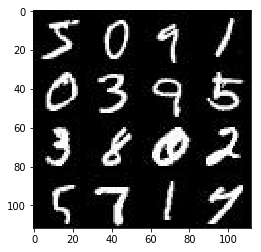

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

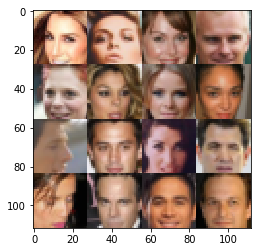

In [4]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return input_images, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    #Putting 4 instead of 3 convolutional layers seems to drive the generator loss lower than the discriminator loss more efficiently.
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x0 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x0 = tf.maximum(alpha * x0, x0)
                
        x1 = tf.layers.conv2d(x0, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.7)
        
        x2 = tf.layers.conv2d(x1, filters=256, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.7)
        
        x3 = tf.layers.conv2d(x2, filters=512, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.7)

        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x0 = tf.layers.dense(z, 7*7*512)

        x0 = tf.reshape(x0, (-1, 7, 7, 512))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)

        x1 = tf.layers.conv2d_transpose(x0, filters=256, kernel_size=5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
       
        output = tf.tanh(logits) 
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    g_vars = [x for x in train_vars if x.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_num, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 #Necessary to change range from -0.5 till 0.5 to -1 till 1
                                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) #generates random noise for the generator

                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                # Calculate losses and print them out after each 10 steps
                steps +=1 
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} -- ".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f} -- ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                #Print image
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 --  Discriminator Loss: 0.3733 --  Generator Loss: 4.6563
Epoch 1/2 --  Discriminator Loss: 0.5700 --  Generator Loss: 6.5453
Epoch 1/2 --  Discriminator Loss: 2.8910 --  Generator Loss: 11.8894
Epoch 1/2 --  Discriminator Loss: 2.7203 --  Generator Loss: 2.6465
Epoch 1/2 --  Discriminator Loss: 2.0311 --  Generator Loss: 0.4331
Epoch 1/2 --  Discriminator Loss: 1.1468 --  Generator Loss: 2.1158
Epoch 1/2 --  Discriminator Loss: 1.8715 --  Generator Loss: 0.8496
Epoch 1/2 --  Discriminator Loss: 1.4656 --  Generator Loss: 1.1980
Epoch 1/2 --  Discriminator Loss: 1.5832 --  Generator Loss: 0.5612
Epoch 1/2 --  Discriminator Loss: 1.4066 --  Generator Loss: 2.0632


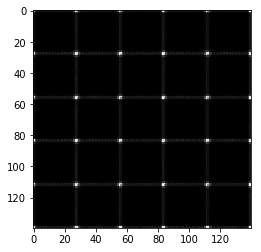

Epoch 1/2 --  Discriminator Loss: 2.3234 --  Generator Loss: 1.7127
Epoch 1/2 --  Discriminator Loss: 2.1178 --  Generator Loss: 0.5536
Epoch 1/2 --  Discriminator Loss: 1.6446 --  Generator Loss: 1.1644
Epoch 1/2 --  Discriminator Loss: 1.5104 --  Generator Loss: 0.8540
Epoch 1/2 --  Discriminator Loss: 1.7961 --  Generator Loss: 0.5320
Epoch 1/2 --  Discriminator Loss: 1.5703 --  Generator Loss: 0.2794
Epoch 1/2 --  Discriminator Loss: 1.7138 --  Generator Loss: 0.7389
Epoch 1/2 --  Discriminator Loss: 1.6954 --  Generator Loss: 0.8015
Epoch 1/2 --  Discriminator Loss: 1.2607 --  Generator Loss: 0.6501
Epoch 1/2 --  Discriminator Loss: 1.3656 --  Generator Loss: 0.7676


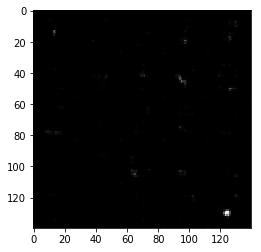

Epoch 1/2 --  Discriminator Loss: 1.6699 --  Generator Loss: 0.8659
Epoch 1/2 --  Discriminator Loss: 1.5202 --  Generator Loss: 0.9129
Epoch 1/2 --  Discriminator Loss: 1.4649 --  Generator Loss: 0.6831
Epoch 1/2 --  Discriminator Loss: 1.4665 --  Generator Loss: 0.5098
Epoch 1/2 --  Discriminator Loss: 1.3848 --  Generator Loss: 1.0934
Epoch 1/2 --  Discriminator Loss: 1.3996 --  Generator Loss: 1.4987
Epoch 1/2 --  Discriminator Loss: 1.2116 --  Generator Loss: 1.1322
Epoch 1/2 --  Discriminator Loss: 1.5241 --  Generator Loss: 1.0397
Epoch 1/2 --  Discriminator Loss: 1.5182 --  Generator Loss: 0.5551
Epoch 1/2 --  Discriminator Loss: 1.5584 --  Generator Loss: 0.6800


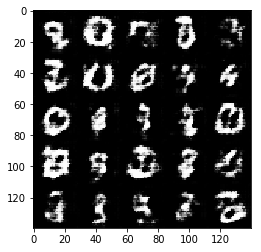

Epoch 1/2 --  Discriminator Loss: 1.5220 --  Generator Loss: 1.0056
Epoch 1/2 --  Discriminator Loss: 1.4447 --  Generator Loss: 0.6548
Epoch 1/2 --  Discriminator Loss: 1.4509 --  Generator Loss: 0.7362
Epoch 1/2 --  Discriminator Loss: 1.6983 --  Generator Loss: 0.8342
Epoch 1/2 --  Discriminator Loss: 1.4311 --  Generator Loss: 1.0729
Epoch 1/2 --  Discriminator Loss: 1.8685 --  Generator Loss: 0.6992
Epoch 1/2 --  Discriminator Loss: 1.3699 --  Generator Loss: 1.4822
Epoch 1/2 --  Discriminator Loss: 1.5395 --  Generator Loss: 1.1524
Epoch 1/2 --  Discriminator Loss: 1.9179 --  Generator Loss: 0.5683
Epoch 1/2 --  Discriminator Loss: 1.8278 --  Generator Loss: 0.4985


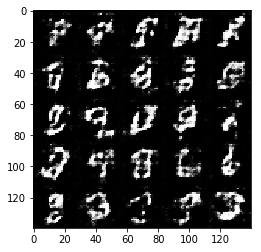

Epoch 1/2 --  Discriminator Loss: 1.2810 --  Generator Loss: 0.6895
Epoch 1/2 --  Discriminator Loss: 1.2370 --  Generator Loss: 1.4003
Epoch 1/2 --  Discriminator Loss: 1.3018 --  Generator Loss: 1.0946
Epoch 1/2 --  Discriminator Loss: 1.2036 --  Generator Loss: 1.3450
Epoch 1/2 --  Discriminator Loss: 1.1257 --  Generator Loss: 1.4528
Epoch 1/2 --  Discriminator Loss: 1.3211 --  Generator Loss: 0.9683
Epoch 1/2 --  Discriminator Loss: 1.6427 --  Generator Loss: 0.6655
Epoch 1/2 --  Discriminator Loss: 1.9981 --  Generator Loss: 0.3533
Epoch 1/2 --  Discriminator Loss: 1.7107 --  Generator Loss: 0.8520
Epoch 1/2 --  Discriminator Loss: 1.5989 --  Generator Loss: 0.8626


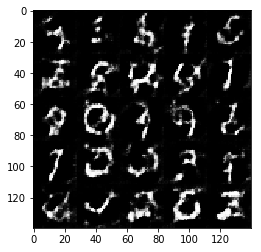

Epoch 1/2 --  Discriminator Loss: 1.5766 --  Generator Loss: 0.8774
Epoch 1/2 --  Discriminator Loss: 1.4133 --  Generator Loss: 1.1931
Epoch 1/2 --  Discriminator Loss: 1.5078 --  Generator Loss: 0.6212
Epoch 1/2 --  Discriminator Loss: 1.1514 --  Generator Loss: 1.5387
Epoch 1/2 --  Discriminator Loss: 1.4987 --  Generator Loss: 1.6830
Epoch 1/2 --  Discriminator Loss: 1.4422 --  Generator Loss: 0.6463
Epoch 1/2 --  Discriminator Loss: 1.4277 --  Generator Loss: 0.5358
Epoch 1/2 --  Discriminator Loss: 1.3981 --  Generator Loss: 0.8839
Epoch 1/2 --  Discriminator Loss: 1.6246 --  Generator Loss: 0.8025
Epoch 1/2 --  Discriminator Loss: 1.4844 --  Generator Loss: 0.5331


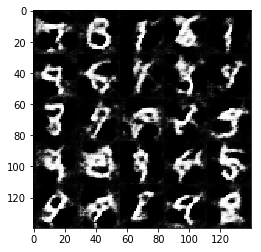

Epoch 1/2 --  Discriminator Loss: 1.5273 --  Generator Loss: 0.7033
Epoch 1/2 --  Discriminator Loss: 1.5308 --  Generator Loss: 0.7429
Epoch 1/2 --  Discriminator Loss: 1.3247 --  Generator Loss: 0.6446
Epoch 1/2 --  Discriminator Loss: 1.3276 --  Generator Loss: 1.0895
Epoch 1/2 --  Discriminator Loss: 1.8514 --  Generator Loss: 1.6819
Epoch 1/2 --  Discriminator Loss: 1.4218 --  Generator Loss: 0.6454
Epoch 1/2 --  Discriminator Loss: 1.3366 --  Generator Loss: 0.8357
Epoch 1/2 --  Discriminator Loss: 1.4122 --  Generator Loss: 0.9413
Epoch 1/2 --  Discriminator Loss: 1.4327 --  Generator Loss: 0.9499
Epoch 1/2 --  Discriminator Loss: 1.4379 --  Generator Loss: 0.4366


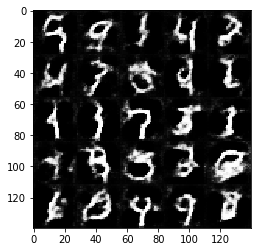

Epoch 1/2 --  Discriminator Loss: 1.3878 --  Generator Loss: 0.5554
Epoch 1/2 --  Discriminator Loss: 1.5415 --  Generator Loss: 0.7448
Epoch 1/2 --  Discriminator Loss: 1.7013 --  Generator Loss: 1.2428
Epoch 1/2 --  Discriminator Loss: 1.4742 --  Generator Loss: 1.6520
Epoch 1/2 --  Discriminator Loss: 1.2335 --  Generator Loss: 0.9007
Epoch 1/2 --  Discriminator Loss: 1.1816 --  Generator Loss: 0.9775
Epoch 1/2 --  Discriminator Loss: 1.4202 --  Generator Loss: 0.7801
Epoch 1/2 --  Discriminator Loss: 1.5998 --  Generator Loss: 0.5218
Epoch 1/2 --  Discriminator Loss: 1.7607 --  Generator Loss: 0.3311
Epoch 1/2 --  Discriminator Loss: 1.4928 --  Generator Loss: 0.7868


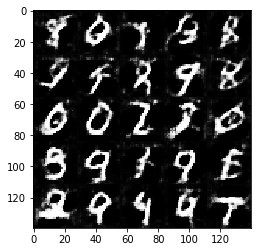

Epoch 1/2 --  Discriminator Loss: 1.4314 --  Generator Loss: 0.6989
Epoch 1/2 --  Discriminator Loss: 1.2624 --  Generator Loss: 0.5963
Epoch 1/2 --  Discriminator Loss: 1.1543 --  Generator Loss: 0.9590
Epoch 1/2 --  Discriminator Loss: 1.3805 --  Generator Loss: 0.7671
Epoch 1/2 --  Discriminator Loss: 1.0489 --  Generator Loss: 1.2334
Epoch 1/2 --  Discriminator Loss: 1.4982 --  Generator Loss: 0.6991
Epoch 1/2 --  Discriminator Loss: 1.5458 --  Generator Loss: 1.1300
Epoch 1/2 --  Discriminator Loss: 1.2524 --  Generator Loss: 0.9336
Epoch 1/2 --  Discriminator Loss: 1.3850 --  Generator Loss: 0.9825
Epoch 1/2 --  Discriminator Loss: 1.2610 --  Generator Loss: 0.6688


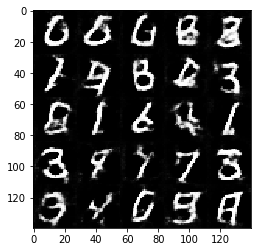

Epoch 1/2 --  Discriminator Loss: 1.4385 --  Generator Loss: 0.5454
Epoch 1/2 --  Discriminator Loss: 1.3566 --  Generator Loss: 0.6808
Epoch 1/2 --  Discriminator Loss: 1.3667 --  Generator Loss: 0.9940
Epoch 2/2 --  Discriminator Loss: 1.2934 --  Generator Loss: 1.1739
Epoch 2/2 --  Discriminator Loss: 1.2684 --  Generator Loss: 1.0463
Epoch 2/2 --  Discriminator Loss: 1.2171 --  Generator Loss: 1.3252
Epoch 2/2 --  Discriminator Loss: 1.5856 --  Generator Loss: 0.3615
Epoch 2/2 --  Discriminator Loss: 1.3007 --  Generator Loss: 0.6795
Epoch 2/2 --  Discriminator Loss: 1.4132 --  Generator Loss: 1.2281
Epoch 2/2 --  Discriminator Loss: 1.4631 --  Generator Loss: 1.1594


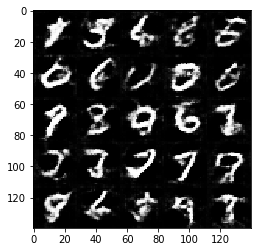

Epoch 2/2 --  Discriminator Loss: 1.2546 --  Generator Loss: 0.9700
Epoch 2/2 --  Discriminator Loss: 1.1716 --  Generator Loss: 0.8279
Epoch 2/2 --  Discriminator Loss: 1.2069 --  Generator Loss: 1.4689
Epoch 2/2 --  Discriminator Loss: 1.6046 --  Generator Loss: 0.5183
Epoch 2/2 --  Discriminator Loss: 1.2195 --  Generator Loss: 1.0882
Epoch 2/2 --  Discriminator Loss: 1.2629 --  Generator Loss: 1.2907
Epoch 2/2 --  Discriminator Loss: 1.3618 --  Generator Loss: 1.3432
Epoch 2/2 --  Discriminator Loss: 1.4290 --  Generator Loss: 0.5991
Epoch 2/2 --  Discriminator Loss: 1.4630 --  Generator Loss: 0.4591
Epoch 2/2 --  Discriminator Loss: 1.6874 --  Generator Loss: 0.5297


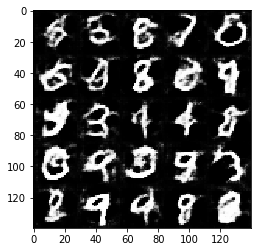

Epoch 2/2 --  Discriminator Loss: 0.8995 --  Generator Loss: 1.5863
Epoch 2/2 --  Discriminator Loss: 1.4161 --  Generator Loss: 0.6020
Epoch 2/2 --  Discriminator Loss: 0.9720 --  Generator Loss: 1.2454
Epoch 2/2 --  Discriminator Loss: 1.1817 --  Generator Loss: 1.0661
Epoch 2/2 --  Discriminator Loss: 1.4200 --  Generator Loss: 0.7220
Epoch 2/2 --  Discriminator Loss: 1.0341 --  Generator Loss: 0.7384
Epoch 2/2 --  Discriminator Loss: 1.3170 --  Generator Loss: 0.8301
Epoch 2/2 --  Discriminator Loss: 1.1807 --  Generator Loss: 1.2198
Epoch 2/2 --  Discriminator Loss: 1.8618 --  Generator Loss: 0.3284
Epoch 2/2 --  Discriminator Loss: 1.3104 --  Generator Loss: 0.9241


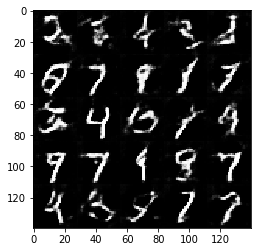

Epoch 2/2 --  Discriminator Loss: 1.0178 --  Generator Loss: 1.5272
Epoch 2/2 --  Discriminator Loss: 1.4999 --  Generator Loss: 1.6003
Epoch 2/2 --  Discriminator Loss: 1.0620 --  Generator Loss: 1.0957
Epoch 2/2 --  Discriminator Loss: 1.2179 --  Generator Loss: 0.7939
Epoch 2/2 --  Discriminator Loss: 1.3630 --  Generator Loss: 1.5199
Epoch 2/2 --  Discriminator Loss: 1.4723 --  Generator Loss: 0.8439
Epoch 2/2 --  Discriminator Loss: 1.1933 --  Generator Loss: 1.4749
Epoch 2/2 --  Discriminator Loss: 1.6634 --  Generator Loss: 0.5294
Epoch 2/2 --  Discriminator Loss: 1.2623 --  Generator Loss: 1.6784
Epoch 2/2 --  Discriminator Loss: 1.1441 --  Generator Loss: 1.1011


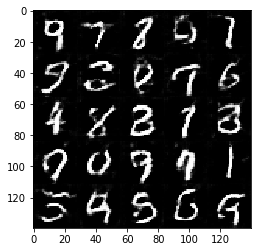

Epoch 2/2 --  Discriminator Loss: 1.1324 --  Generator Loss: 0.7717
Epoch 2/2 --  Discriminator Loss: 1.4732 --  Generator Loss: 0.6425
Epoch 2/2 --  Discriminator Loss: 1.5977 --  Generator Loss: 1.1084
Epoch 2/2 --  Discriminator Loss: 1.5565 --  Generator Loss: 0.4838
Epoch 2/2 --  Discriminator Loss: 1.3936 --  Generator Loss: 0.8382
Epoch 2/2 --  Discriminator Loss: 1.2392 --  Generator Loss: 1.2244
Epoch 2/2 --  Discriminator Loss: 1.0582 --  Generator Loss: 0.9990
Epoch 2/2 --  Discriminator Loss: 1.2072 --  Generator Loss: 0.8066
Epoch 2/2 --  Discriminator Loss: 0.9670 --  Generator Loss: 1.6378
Epoch 2/2 --  Discriminator Loss: 1.4962 --  Generator Loss: 1.0795


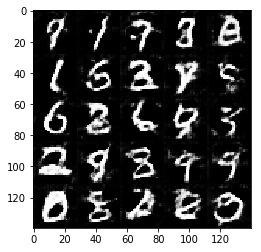

Epoch 2/2 --  Discriminator Loss: 0.9560 --  Generator Loss: 0.9208
Epoch 2/2 --  Discriminator Loss: 1.3339 --  Generator Loss: 1.1791
Epoch 2/2 --  Discriminator Loss: 1.6206 --  Generator Loss: 0.3803
Epoch 2/2 --  Discriminator Loss: 1.0945 --  Generator Loss: 0.6408
Epoch 2/2 --  Discriminator Loss: 1.4553 --  Generator Loss: 1.8683
Epoch 2/2 --  Discriminator Loss: 1.3576 --  Generator Loss: 0.8518
Epoch 2/2 --  Discriminator Loss: 1.3044 --  Generator Loss: 0.8530
Epoch 2/2 --  Discriminator Loss: 1.4405 --  Generator Loss: 1.0148
Epoch 2/2 --  Discriminator Loss: 1.5777 --  Generator Loss: 0.4951
Epoch 2/2 --  Discriminator Loss: 1.0928 --  Generator Loss: 1.6046


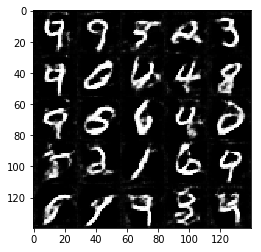

Epoch 2/2 --  Discriminator Loss: 1.6240 --  Generator Loss: 0.3250
Epoch 2/2 --  Discriminator Loss: 1.0339 --  Generator Loss: 0.8442
Epoch 2/2 --  Discriminator Loss: 1.7361 --  Generator Loss: 0.3299
Epoch 2/2 --  Discriminator Loss: 1.4859 --  Generator Loss: 0.4648
Epoch 2/2 --  Discriminator Loss: 0.9472 --  Generator Loss: 1.3217
Epoch 2/2 --  Discriminator Loss: 1.2090 --  Generator Loss: 1.6642
Epoch 2/2 --  Discriminator Loss: 1.3447 --  Generator Loss: 0.4854
Epoch 2/2 --  Discriminator Loss: 1.1692 --  Generator Loss: 0.8413
Epoch 2/2 --  Discriminator Loss: 1.5946 --  Generator Loss: 0.3288
Epoch 2/2 --  Discriminator Loss: 1.3443 --  Generator Loss: 1.6522


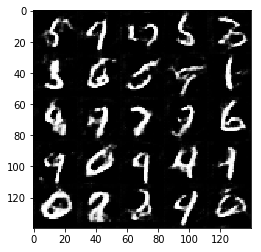

Epoch 2/2 --  Discriminator Loss: 1.2453 --  Generator Loss: 1.1774
Epoch 2/2 --  Discriminator Loss: 1.2737 --  Generator Loss: 0.8712
Epoch 2/2 --  Discriminator Loss: 1.3307 --  Generator Loss: 0.6253
Epoch 2/2 --  Discriminator Loss: 1.6303 --  Generator Loss: 0.5128
Epoch 2/2 --  Discriminator Loss: 1.2870 --  Generator Loss: 0.6952
Epoch 2/2 --  Discriminator Loss: 1.1770 --  Generator Loss: 0.5507
Epoch 2/2 --  Discriminator Loss: 1.3247 --  Generator Loss: 0.7241
Epoch 2/2 --  Discriminator Loss: 1.2286 --  Generator Loss: 1.1321
Epoch 2/2 --  Discriminator Loss: 1.2902 --  Generator Loss: 0.6171
Epoch 2/2 --  Discriminator Loss: 1.3745 --  Generator Loss: 0.6658


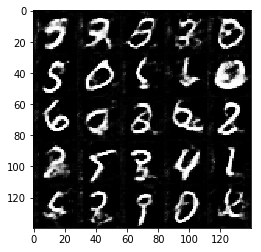

Epoch 2/2 --  Discriminator Loss: 1.3373 --  Generator Loss: 0.6765
Epoch 2/2 --  Discriminator Loss: 1.5877 --  Generator Loss: 0.4608
Epoch 2/2 --  Discriminator Loss: 1.5003 --  Generator Loss: 0.5294
Epoch 2/2 --  Discriminator Loss: 1.4218 --  Generator Loss: 1.0361
Epoch 2/2 --  Discriminator Loss: 1.0257 --  Generator Loss: 0.9161
Epoch 2/2 --  Discriminator Loss: 1.0115 --  Generator Loss: 0.8020
Epoch 2/2 --  Discriminator Loss: 0.9759 --  Generator Loss: 1.2900
Epoch 2/2 --  Discriminator Loss: 1.4473 --  Generator Loss: 0.4173
Epoch 2/2 --  Discriminator Loss: 1.0040 --  Generator Loss: 1.3901
Epoch 2/2 --  Discriminator Loss: 1.1309 --  Generator Loss: 0.5831


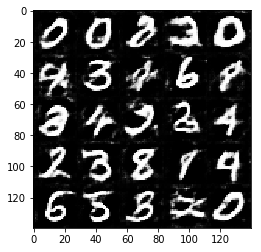

Epoch 2/2 --  Discriminator Loss: 1.5668 --  Generator Loss: 0.4305
Epoch 2/2 --  Discriminator Loss: 1.3636 --  Generator Loss: 0.7198
Epoch 2/2 --  Discriminator Loss: 1.6594 --  Generator Loss: 0.3602
Epoch 2/2 --  Discriminator Loss: 1.4570 --  Generator Loss: 0.8563
Epoch 2/2 --  Discriminator Loss: 1.0797 --  Generator Loss: 0.9530
Epoch 2/2 --  Discriminator Loss: 1.1521 --  Generator Loss: 1.0266
Epoch 2/2 --  Discriminator Loss: 1.4652 --  Generator Loss: 0.5675


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 --  Discriminator Loss: 0.9476 --  Generator Loss: 9.4210
Epoch 1/1 --  Discriminator Loss: 0.4650 --  Generator Loss: 3.5563
Epoch 1/1 --  Discriminator Loss: 4.0920 --  Generator Loss: 0.0533
Epoch 1/1 --  Discriminator Loss: 3.2499 --  Generator Loss: 0.1442
Epoch 1/1 --  Discriminator Loss: 2.4189 --  Generator Loss: 6.0584
Epoch 1/1 --  Discriminator Loss: 1.1078 --  Generator Loss: 1.1038
Epoch 1/1 --  Discriminator Loss: 1.7859 --  Generator Loss: 0.7097
Epoch 1/1 --  Discriminator Loss: 2.9938 --  Generator Loss: 0.1653
Epoch 1/1 --  Discriminator Loss: 2.6504 --  Generator Loss: 5.7366
Epoch 1/1 --  Discriminator Loss: 3.2331 --  Generator Loss: 0.0703


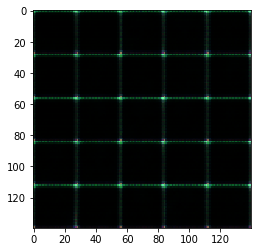

Epoch 1/1 --  Discriminator Loss: 1.4652 --  Generator Loss: 0.6291
Epoch 1/1 --  Discriminator Loss: 0.8823 --  Generator Loss: 1.6669
Epoch 1/1 --  Discriminator Loss: 1.1559 --  Generator Loss: 0.8458
Epoch 1/1 --  Discriminator Loss: 0.7614 --  Generator Loss: 1.8103
Epoch 1/1 --  Discriminator Loss: 1.5919 --  Generator Loss: 0.5020
Epoch 1/1 --  Discriminator Loss: 0.7193 --  Generator Loss: 1.7345
Epoch 1/1 --  Discriminator Loss: 0.7912 --  Generator Loss: 1.9400
Epoch 1/1 --  Discriminator Loss: 0.9939 --  Generator Loss: 1.4762
Epoch 1/1 --  Discriminator Loss: 1.5281 --  Generator Loss: 1.0744
Epoch 1/1 --  Discriminator Loss: 1.9836 --  Generator Loss: 4.4021


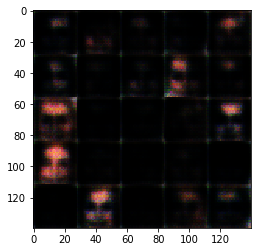

Epoch 1/1 --  Discriminator Loss: 1.3481 --  Generator Loss: 0.6377
Epoch 1/1 --  Discriminator Loss: 1.1347 --  Generator Loss: 1.4922
Epoch 1/1 --  Discriminator Loss: 1.0417 --  Generator Loss: 3.4052
Epoch 1/1 --  Discriminator Loss: 2.3026 --  Generator Loss: 0.2524
Epoch 1/1 --  Discriminator Loss: 1.3093 --  Generator Loss: 0.6511
Epoch 1/1 --  Discriminator Loss: 1.3854 --  Generator Loss: 0.4851
Epoch 1/1 --  Discriminator Loss: 1.0188 --  Generator Loss: 1.0317
Epoch 1/1 --  Discriminator Loss: 1.4319 --  Generator Loss: 0.9890
Epoch 1/1 --  Discriminator Loss: 1.5484 --  Generator Loss: 0.5710
Epoch 1/1 --  Discriminator Loss: 1.1023 --  Generator Loss: 1.8402


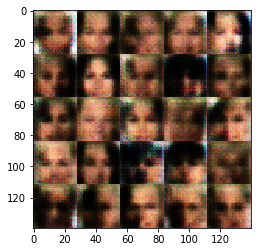

Epoch 1/1 --  Discriminator Loss: 0.8366 --  Generator Loss: 1.9799
Epoch 1/1 --  Discriminator Loss: 1.0354 --  Generator Loss: 1.0462
Epoch 1/1 --  Discriminator Loss: 1.1873 --  Generator Loss: 0.9568
Epoch 1/1 --  Discriminator Loss: 0.6839 --  Generator Loss: 2.1105
Epoch 1/1 --  Discriminator Loss: 0.6375 --  Generator Loss: 2.6596
Epoch 1/1 --  Discriminator Loss: 0.9858 --  Generator Loss: 0.9182
Epoch 1/1 --  Discriminator Loss: 1.4898 --  Generator Loss: 2.5198
Epoch 1/1 --  Discriminator Loss: 1.5867 --  Generator Loss: 0.6155
Epoch 1/1 --  Discriminator Loss: 0.8255 --  Generator Loss: 1.3845
Epoch 1/1 --  Discriminator Loss: 1.7032 --  Generator Loss: 0.6778


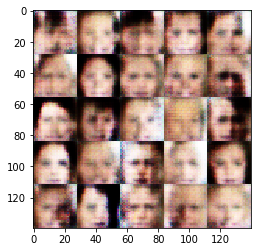

Epoch 1/1 --  Discriminator Loss: 2.5190 --  Generator Loss: 0.1961
Epoch 1/1 --  Discriminator Loss: 1.4600 --  Generator Loss: 0.7320
Epoch 1/1 --  Discriminator Loss: 1.7018 --  Generator Loss: 0.4894
Epoch 1/1 --  Discriminator Loss: 0.6184 --  Generator Loss: 1.8235
Epoch 1/1 --  Discriminator Loss: 1.0698 --  Generator Loss: 0.8707
Epoch 1/1 --  Discriminator Loss: 1.3019 --  Generator Loss: 1.5578
Epoch 1/1 --  Discriminator Loss: 1.1923 --  Generator Loss: 2.1277
Epoch 1/1 --  Discriminator Loss: 0.8079 --  Generator Loss: 1.3537
Epoch 1/1 --  Discriminator Loss: 2.0281 --  Generator Loss: 0.3838
Epoch 1/1 --  Discriminator Loss: 1.3722 --  Generator Loss: 0.7992


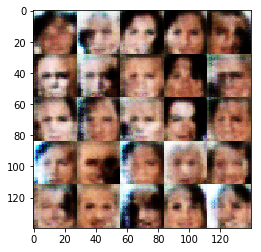

Epoch 1/1 --  Discriminator Loss: 1.0104 --  Generator Loss: 1.5534
Epoch 1/1 --  Discriminator Loss: 1.5390 --  Generator Loss: 0.8041
Epoch 1/1 --  Discriminator Loss: 1.5040 --  Generator Loss: 2.3868
Epoch 1/1 --  Discriminator Loss: 2.3340 --  Generator Loss: 0.2276
Epoch 1/1 --  Discriminator Loss: 1.0369 --  Generator Loss: 1.5004
Epoch 1/1 --  Discriminator Loss: 1.2942 --  Generator Loss: 1.0952
Epoch 1/1 --  Discriminator Loss: 0.9808 --  Generator Loss: 3.0600
Epoch 1/1 --  Discriminator Loss: 1.3079 --  Generator Loss: 0.6411
Epoch 1/1 --  Discriminator Loss: 1.5813 --  Generator Loss: 0.7108
Epoch 1/1 --  Discriminator Loss: 1.3688 --  Generator Loss: 0.7385


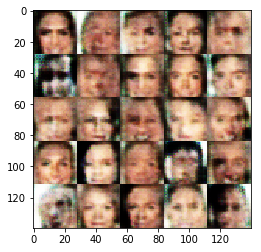

Epoch 1/1 --  Discriminator Loss: 0.7585 --  Generator Loss: 1.6600
Epoch 1/1 --  Discriminator Loss: 1.7141 --  Generator Loss: 0.4499
Epoch 1/1 --  Discriminator Loss: 2.5136 --  Generator Loss: 0.1947
Epoch 1/1 --  Discriminator Loss: 0.7958 --  Generator Loss: 1.2034
Epoch 1/1 --  Discriminator Loss: 0.9590 --  Generator Loss: 1.4959
Epoch 1/1 --  Discriminator Loss: 1.7831 --  Generator Loss: 0.4427
Epoch 1/1 --  Discriminator Loss: 3.8920 --  Generator Loss: 3.1431
Epoch 1/1 --  Discriminator Loss: 1.9839 --  Generator Loss: 0.3742
Epoch 1/1 --  Discriminator Loss: 3.0229 --  Generator Loss: 0.1632
Epoch 1/1 --  Discriminator Loss: 1.1969 --  Generator Loss: 1.0781


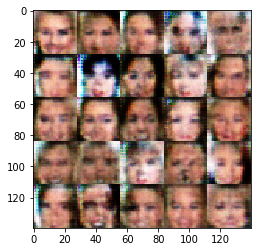

Epoch 1/1 --  Discriminator Loss: 1.3720 --  Generator Loss: 2.5877
Epoch 1/1 --  Discriminator Loss: 1.3527 --  Generator Loss: 0.9201
Epoch 1/1 --  Discriminator Loss: 0.8264 --  Generator Loss: 1.6793
Epoch 1/1 --  Discriminator Loss: 0.8112 --  Generator Loss: 1.5129
Epoch 1/1 --  Discriminator Loss: 1.0629 --  Generator Loss: 1.2430
Epoch 1/1 --  Discriminator Loss: 0.8316 --  Generator Loss: 1.4032
Epoch 1/1 --  Discriminator Loss: 1.6537 --  Generator Loss: 0.5452
Epoch 1/1 --  Discriminator Loss: 1.4618 --  Generator Loss: 0.7234
Epoch 1/1 --  Discriminator Loss: 1.4657 --  Generator Loss: 1.7011
Epoch 1/1 --  Discriminator Loss: 1.1945 --  Generator Loss: 1.3693


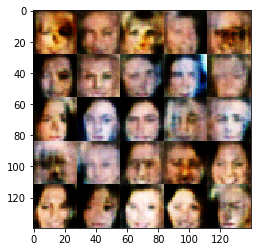

Epoch 1/1 --  Discriminator Loss: 1.2126 --  Generator Loss: 0.8708
Epoch 1/1 --  Discriminator Loss: 1.5435 --  Generator Loss: 0.6463
Epoch 1/1 --  Discriminator Loss: 0.9452 --  Generator Loss: 1.8335
Epoch 1/1 --  Discriminator Loss: 1.0463 --  Generator Loss: 0.6966
Epoch 1/1 --  Discriminator Loss: 1.2088 --  Generator Loss: 1.3199
Epoch 1/1 --  Discriminator Loss: 1.2731 --  Generator Loss: 0.6428
Epoch 1/1 --  Discriminator Loss: 1.2572 --  Generator Loss: 0.9103
Epoch 1/1 --  Discriminator Loss: 1.9145 --  Generator Loss: 0.6782
Epoch 1/1 --  Discriminator Loss: 0.8665 --  Generator Loss: 1.3995
Epoch 1/1 --  Discriminator Loss: 1.0741 --  Generator Loss: 0.9551


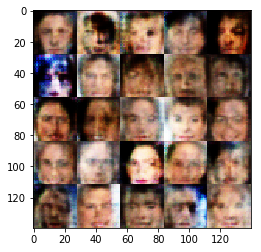

Epoch 1/1 --  Discriminator Loss: 1.1353 --  Generator Loss: 1.2959
Epoch 1/1 --  Discriminator Loss: 1.7518 --  Generator Loss: 0.5894
Epoch 1/1 --  Discriminator Loss: 1.1897 --  Generator Loss: 0.8511
Epoch 1/1 --  Discriminator Loss: 1.3517 --  Generator Loss: 1.4748
Epoch 1/1 --  Discriminator Loss: 0.7839 --  Generator Loss: 1.1782
Epoch 1/1 --  Discriminator Loss: 1.6298 --  Generator Loss: 0.4197
Epoch 1/1 --  Discriminator Loss: 0.9748 --  Generator Loss: 1.3125
Epoch 1/1 --  Discriminator Loss: 1.3687 --  Generator Loss: 0.6279
Epoch 1/1 --  Discriminator Loss: 1.9438 --  Generator Loss: 0.3582
Epoch 1/1 --  Discriminator Loss: 1.3206 --  Generator Loss: 0.6931


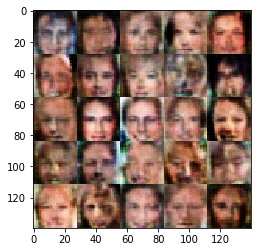

Epoch 1/1 --  Discriminator Loss: 2.0840 --  Generator Loss: 0.2716
Epoch 1/1 --  Discriminator Loss: 1.3239 --  Generator Loss: 0.7809
Epoch 1/1 --  Discriminator Loss: 1.4969 --  Generator Loss: 0.5367
Epoch 1/1 --  Discriminator Loss: 0.5894 --  Generator Loss: 4.1587
Epoch 1/1 --  Discriminator Loss: 1.6535 --  Generator Loss: 0.5836
Epoch 1/1 --  Discriminator Loss: 1.8388 --  Generator Loss: 1.8467
Epoch 1/1 --  Discriminator Loss: 2.4370 --  Generator Loss: 0.1981
Epoch 1/1 --  Discriminator Loss: 1.2060 --  Generator Loss: 0.7970
Epoch 1/1 --  Discriminator Loss: 1.5652 --  Generator Loss: 0.8025
Epoch 1/1 --  Discriminator Loss: 1.1531 --  Generator Loss: 0.6687


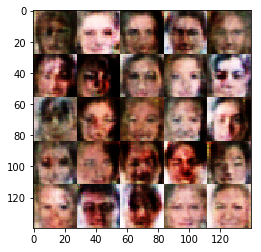

Epoch 1/1 --  Discriminator Loss: 1.4246 --  Generator Loss: 0.5912
Epoch 1/1 --  Discriminator Loss: 1.4027 --  Generator Loss: 2.0514
Epoch 1/1 --  Discriminator Loss: 0.6087 --  Generator Loss: 2.5894
Epoch 1/1 --  Discriminator Loss: 0.8699 --  Generator Loss: 2.0122
Epoch 1/1 --  Discriminator Loss: 1.4330 --  Generator Loss: 1.5075
Epoch 1/1 --  Discriminator Loss: 1.2040 --  Generator Loss: 0.8154
Epoch 1/1 --  Discriminator Loss: 1.9596 --  Generator Loss: 2.2830
Epoch 1/1 --  Discriminator Loss: 1.6994 --  Generator Loss: 0.3999
Epoch 1/1 --  Discriminator Loss: 1.3429 --  Generator Loss: 1.0218
Epoch 1/1 --  Discriminator Loss: 1.1360 --  Generator Loss: 0.6990


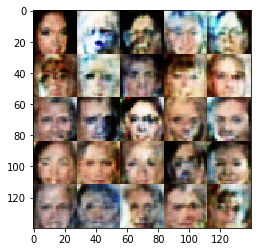

Epoch 1/1 --  Discriminator Loss: 1.0730 --  Generator Loss: 0.7974
Epoch 1/1 --  Discriminator Loss: 1.5401 --  Generator Loss: 0.4633
Epoch 1/1 --  Discriminator Loss: 0.7489 --  Generator Loss: 1.5380
Epoch 1/1 --  Discriminator Loss: 1.0300 --  Generator Loss: 1.1647
Epoch 1/1 --  Discriminator Loss: 0.9845 --  Generator Loss: 0.9828
Epoch 1/1 --  Discriminator Loss: 1.5598 --  Generator Loss: 0.4326
Epoch 1/1 --  Discriminator Loss: 1.3631 --  Generator Loss: 0.7045
Epoch 1/1 --  Discriminator Loss: 1.1371 --  Generator Loss: 1.3173
Epoch 1/1 --  Discriminator Loss: 1.2799 --  Generator Loss: 0.7158
Epoch 1/1 --  Discriminator Loss: 1.1190 --  Generator Loss: 0.7385


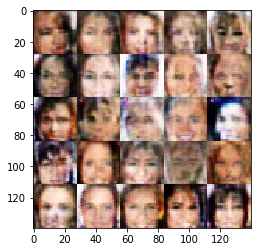

Epoch 1/1 --  Discriminator Loss: 1.5668 --  Generator Loss: 0.4857
Epoch 1/1 --  Discriminator Loss: 1.4502 --  Generator Loss: 0.6175
Epoch 1/1 --  Discriminator Loss: 1.1509 --  Generator Loss: 0.8665
Epoch 1/1 --  Discriminator Loss: 0.6054 --  Generator Loss: 2.3421
Epoch 1/1 --  Discriminator Loss: 1.1113 --  Generator Loss: 0.7695
Epoch 1/1 --  Discriminator Loss: 0.7481 --  Generator Loss: 1.8602
Epoch 1/1 --  Discriminator Loss: 0.9930 --  Generator Loss: 1.1687
Epoch 1/1 --  Discriminator Loss: 2.3300 --  Generator Loss: 0.2293
Epoch 1/1 --  Discriminator Loss: 0.5767 --  Generator Loss: 1.9897
Epoch 1/1 --  Discriminator Loss: 1.1883 --  Generator Loss: 1.9397


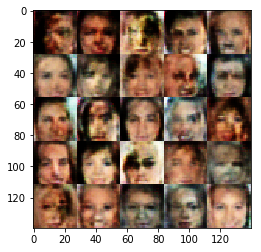

Epoch 1/1 --  Discriminator Loss: 0.8957 --  Generator Loss: 1.4838
Epoch 1/1 --  Discriminator Loss: 1.6481 --  Generator Loss: 0.3581
Epoch 1/1 --  Discriminator Loss: 1.1010 --  Generator Loss: 0.6689
Epoch 1/1 --  Discriminator Loss: 1.3708 --  Generator Loss: 0.7005
Epoch 1/1 --  Discriminator Loss: 1.4622 --  Generator Loss: 0.6375
Epoch 1/1 --  Discriminator Loss: 1.1691 --  Generator Loss: 0.8960
Epoch 1/1 --  Discriminator Loss: 1.2092 --  Generator Loss: 1.0922
Epoch 1/1 --  Discriminator Loss: 1.4315 --  Generator Loss: 0.6211
Epoch 1/1 --  Discriminator Loss: 1.6138 --  Generator Loss: 0.4005
Epoch 1/1 --  Discriminator Loss: 1.5332 --  Generator Loss: 0.4730


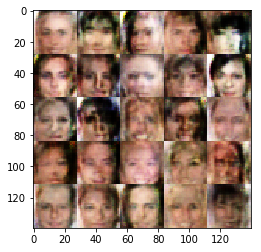

Epoch 1/1 --  Discriminator Loss: 1.2470 --  Generator Loss: 1.1405
Epoch 1/1 --  Discriminator Loss: 1.4912 --  Generator Loss: 0.6771
Epoch 1/1 --  Discriminator Loss: 1.0956 --  Generator Loss: 0.6067
Epoch 1/1 --  Discriminator Loss: 1.3753 --  Generator Loss: 0.6841
Epoch 1/1 --  Discriminator Loss: 1.0860 --  Generator Loss: 0.9765
Epoch 1/1 --  Discriminator Loss: 1.1949 --  Generator Loss: 1.0791
Epoch 1/1 --  Discriminator Loss: 1.3285 --  Generator Loss: 0.6660
Epoch 1/1 --  Discriminator Loss: 1.5371 --  Generator Loss: 0.5357
Epoch 1/1 --  Discriminator Loss: 1.0584 --  Generator Loss: 1.6024
Epoch 1/1 --  Discriminator Loss: 1.1028 --  Generator Loss: 0.7370


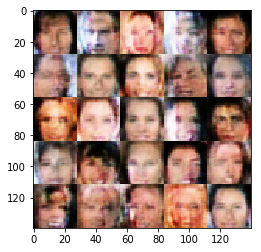

Epoch 1/1 --  Discriminator Loss: 1.6803 --  Generator Loss: 2.4074
Epoch 1/1 --  Discriminator Loss: 1.3705 --  Generator Loss: 0.5781
Epoch 1/1 --  Discriminator Loss: 1.4671 --  Generator Loss: 1.2798
Epoch 1/1 --  Discriminator Loss: 1.5499 --  Generator Loss: 1.3207
Epoch 1/1 --  Discriminator Loss: 1.0465 --  Generator Loss: 1.8239
Epoch 1/1 --  Discriminator Loss: 1.1751 --  Generator Loss: 0.9836
Epoch 1/1 --  Discriminator Loss: 0.7880 --  Generator Loss: 1.5239
Epoch 1/1 --  Discriminator Loss: 1.4784 --  Generator Loss: 0.4828
Epoch 1/1 --  Discriminator Loss: 1.2099 --  Generator Loss: 1.0091
Epoch 1/1 --  Discriminator Loss: 0.9552 --  Generator Loss: 1.1345


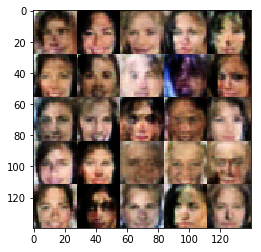

Epoch 1/1 --  Discriminator Loss: 0.6892 --  Generator Loss: 1.7986
Epoch 1/1 --  Discriminator Loss: 1.8591 --  Generator Loss: 0.3523
Epoch 1/1 --  Discriminator Loss: 1.3190 --  Generator Loss: 1.1967
Epoch 1/1 --  Discriminator Loss: 1.0049 --  Generator Loss: 0.7872
Epoch 1/1 --  Discriminator Loss: 1.0387 --  Generator Loss: 1.0451
Epoch 1/1 --  Discriminator Loss: 1.3774 --  Generator Loss: 0.8104
Epoch 1/1 --  Discriminator Loss: 1.1619 --  Generator Loss: 1.0718
Epoch 1/1 --  Discriminator Loss: 1.0176 --  Generator Loss: 0.6854
Epoch 1/1 --  Discriminator Loss: 1.1924 --  Generator Loss: 0.9047
Epoch 1/1 --  Discriminator Loss: 1.2762 --  Generator Loss: 2.1192


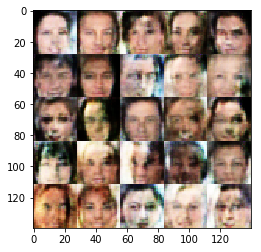

Epoch 1/1 --  Discriminator Loss: 0.5391 --  Generator Loss: 1.7431
Epoch 1/1 --  Discriminator Loss: 1.3921 --  Generator Loss: 0.9124
Epoch 1/1 --  Discriminator Loss: 2.3036 --  Generator Loss: 0.1639
Epoch 1/1 --  Discriminator Loss: 1.2962 --  Generator Loss: 0.5394
Epoch 1/1 --  Discriminator Loss: 2.0848 --  Generator Loss: 0.2893
Epoch 1/1 --  Discriminator Loss: 1.0308 --  Generator Loss: 0.8828
Epoch 1/1 --  Discriminator Loss: 0.6409 --  Generator Loss: 2.1641
Epoch 1/1 --  Discriminator Loss: 2.3297 --  Generator Loss: 0.1728
Epoch 1/1 --  Discriminator Loss: 1.1795 --  Generator Loss: 0.7816
Epoch 1/1 --  Discriminator Loss: 2.1090 --  Generator Loss: 0.3167


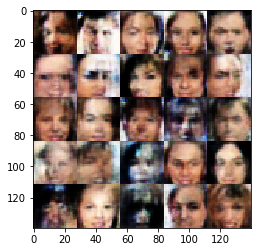

Epoch 1/1 --  Discriminator Loss: 1.1549 --  Generator Loss: 1.3355
Epoch 1/1 --  Discriminator Loss: 0.7702 --  Generator Loss: 1.6337
Epoch 1/1 --  Discriminator Loss: 1.0115 --  Generator Loss: 1.2314
Epoch 1/1 --  Discriminator Loss: 1.0191 --  Generator Loss: 1.8160
Epoch 1/1 --  Discriminator Loss: 1.2815 --  Generator Loss: 0.8026
Epoch 1/1 --  Discriminator Loss: 0.8323 --  Generator Loss: 1.5049
Epoch 1/1 --  Discriminator Loss: 1.8570 --  Generator Loss: 0.3103
Epoch 1/1 --  Discriminator Loss: 1.1039 --  Generator Loss: 1.9826
Epoch 1/1 --  Discriminator Loss: 1.3479 --  Generator Loss: 0.8379
Epoch 1/1 --  Discriminator Loss: 0.9433 --  Generator Loss: 1.1605


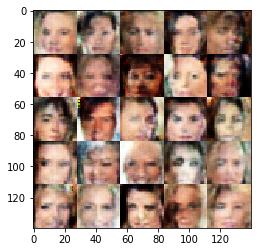

Epoch 1/1 --  Discriminator Loss: 1.1819 --  Generator Loss: 0.7573
Epoch 1/1 --  Discriminator Loss: 0.9137 --  Generator Loss: 0.8973
Epoch 1/1 --  Discriminator Loss: 0.9214 --  Generator Loss: 1.0026
Epoch 1/1 --  Discriminator Loss: 1.1466 --  Generator Loss: 0.6687
Epoch 1/1 --  Discriminator Loss: 1.1420 --  Generator Loss: 0.9602
Epoch 1/1 --  Discriminator Loss: 1.2465 --  Generator Loss: 0.5697
Epoch 1/1 --  Discriminator Loss: 1.7043 --  Generator Loss: 3.8023
Epoch 1/1 --  Discriminator Loss: 1.4631 --  Generator Loss: 0.4930
Epoch 1/1 --  Discriminator Loss: 1.0626 --  Generator Loss: 1.1137
Epoch 1/1 --  Discriminator Loss: 1.3462 --  Generator Loss: 0.6876


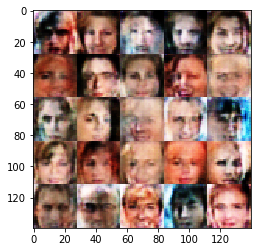

Epoch 1/1 --  Discriminator Loss: 0.8786 --  Generator Loss: 0.9573
Epoch 1/1 --  Discriminator Loss: 0.9304 --  Generator Loss: 1.1334
Epoch 1/1 --  Discriminator Loss: 0.9538 --  Generator Loss: 1.7096
Epoch 1/1 --  Discriminator Loss: 1.1480 --  Generator Loss: 0.9263
Epoch 1/1 --  Discriminator Loss: 1.3968 --  Generator Loss: 0.4276
Epoch 1/1 --  Discriminator Loss: 2.2465 --  Generator Loss: 2.3180
Epoch 1/1 --  Discriminator Loss: 0.9965 --  Generator Loss: 0.8453
Epoch 1/1 --  Discriminator Loss: 1.0973 --  Generator Loss: 0.6205
Epoch 1/1 --  Discriminator Loss: 1.6255 --  Generator Loss: 0.5955
Epoch 1/1 --  Discriminator Loss: 1.1013 --  Generator Loss: 1.1910


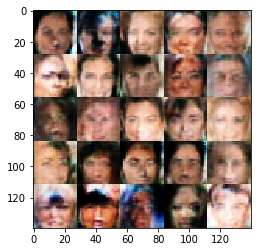

Epoch 1/1 --  Discriminator Loss: 1.9009 --  Generator Loss: 0.2856
Epoch 1/1 --  Discriminator Loss: 1.0825 --  Generator Loss: 0.9590
Epoch 1/1 --  Discriminator Loss: 1.4101 --  Generator Loss: 1.4763
Epoch 1/1 --  Discriminator Loss: 1.3820 --  Generator Loss: 0.8613
Epoch 1/1 --  Discriminator Loss: 1.2349 --  Generator Loss: 1.0141
Epoch 1/1 --  Discriminator Loss: 1.0419 --  Generator Loss: 1.5417
Epoch 1/1 --  Discriminator Loss: 1.5084 --  Generator Loss: 0.6710
Epoch 1/1 --  Discriminator Loss: 0.9005 --  Generator Loss: 1.3493
Epoch 1/1 --  Discriminator Loss: 1.0946 --  Generator Loss: 0.8187
Epoch 1/1 --  Discriminator Loss: 0.7867 --  Generator Loss: 1.3084


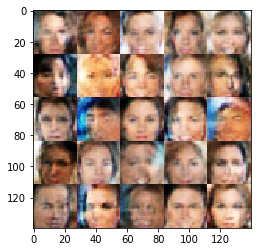

Epoch 1/1 --  Discriminator Loss: 1.2526 --  Generator Loss: 0.8014
Epoch 1/1 --  Discriminator Loss: 0.7978 --  Generator Loss: 0.9759
Epoch 1/1 --  Discriminator Loss: 1.5436 --  Generator Loss: 1.6719
Epoch 1/1 --  Discriminator Loss: 1.3479 --  Generator Loss: 0.8183
Epoch 1/1 --  Discriminator Loss: 1.0673 --  Generator Loss: 1.1751
Epoch 1/1 --  Discriminator Loss: 1.4032 --  Generator Loss: 0.6080
Epoch 1/1 --  Discriminator Loss: 1.2120 --  Generator Loss: 1.4844
Epoch 1/1 --  Discriminator Loss: 1.1110 --  Generator Loss: 0.7868
Epoch 1/1 --  Discriminator Loss: 0.8749 --  Generator Loss: 1.1823
Epoch 1/1 --  Discriminator Loss: 1.0898 --  Generator Loss: 1.0990


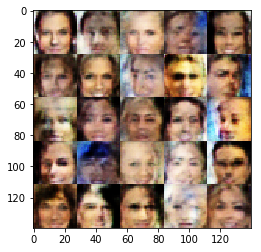

Epoch 1/1 --  Discriminator Loss: 0.7799 --  Generator Loss: 1.5857
Epoch 1/1 --  Discriminator Loss: 0.9079 --  Generator Loss: 1.1222
Epoch 1/1 --  Discriminator Loss: 1.2133 --  Generator Loss: 1.6503
Epoch 1/1 --  Discriminator Loss: 1.0683 --  Generator Loss: 1.5055
Epoch 1/1 --  Discriminator Loss: 1.7369 --  Generator Loss: 1.3862
Epoch 1/1 --  Discriminator Loss: 0.7443 --  Generator Loss: 2.1424
Epoch 1/1 --  Discriminator Loss: 1.0060 --  Generator Loss: 1.6080
Epoch 1/1 --  Discriminator Loss: 1.1413 --  Generator Loss: 0.5879
Epoch 1/1 --  Discriminator Loss: 0.8225 --  Generator Loss: 1.9488
Epoch 1/1 --  Discriminator Loss: 2.3270 --  Generator Loss: 0.1589


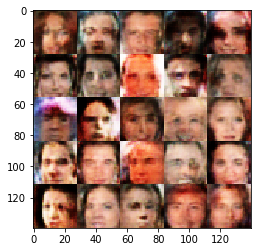

Epoch 1/1 --  Discriminator Loss: 1.5686 --  Generator Loss: 0.4786
Epoch 1/1 --  Discriminator Loss: 0.8342 --  Generator Loss: 1.8242
Epoch 1/1 --  Discriminator Loss: 1.2935 --  Generator Loss: 1.3613
Epoch 1/1 --  Discriminator Loss: 1.6252 --  Generator Loss: 2.4723
Epoch 1/1 --  Discriminator Loss: 1.4717 --  Generator Loss: 0.5406
Epoch 1/1 --  Discriminator Loss: 1.0550 --  Generator Loss: 1.1845
Epoch 1/1 --  Discriminator Loss: 0.8655 --  Generator Loss: 1.3717
Epoch 1/1 --  Discriminator Loss: 0.9414 --  Generator Loss: 1.0728
Epoch 1/1 --  Discriminator Loss: 1.0718 --  Generator Loss: 0.7831
Epoch 1/1 --  Discriminator Loss: 1.4351 --  Generator Loss: 0.4764


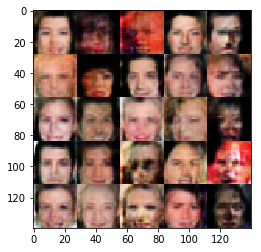

Epoch 1/1 --  Discriminator Loss: 1.5385 --  Generator Loss: 2.6585
Epoch 1/1 --  Discriminator Loss: 0.6458 --  Generator Loss: 1.7926
Epoch 1/1 --  Discriminator Loss: 0.7848 --  Generator Loss: 1.2298
Epoch 1/1 --  Discriminator Loss: 1.2150 --  Generator Loss: 0.8089
Epoch 1/1 --  Discriminator Loss: 1.0653 --  Generator Loss: 0.8546
Epoch 1/1 --  Discriminator Loss: 1.5011 --  Generator Loss: 0.3866
Epoch 1/1 --  Discriminator Loss: 1.1282 --  Generator Loss: 0.6853
Epoch 1/1 --  Discriminator Loss: 0.9377 --  Generator Loss: 1.5977
Epoch 1/1 --  Discriminator Loss: 0.9269 --  Generator Loss: 1.3768
Epoch 1/1 --  Discriminator Loss: 0.9582 --  Generator Loss: 1.1184


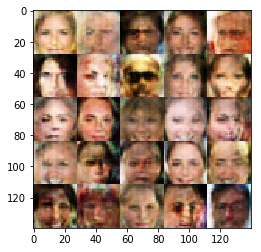

Epoch 1/1 --  Discriminator Loss: 2.0464 --  Generator Loss: 0.1889
Epoch 1/1 --  Discriminator Loss: 1.0862 --  Generator Loss: 0.7829
Epoch 1/1 --  Discriminator Loss: 0.7998 --  Generator Loss: 1.4412
Epoch 1/1 --  Discriminator Loss: 1.4098 --  Generator Loss: 0.7208
Epoch 1/1 --  Discriminator Loss: 1.8394 --  Generator Loss: 0.3141
Epoch 1/1 --  Discriminator Loss: 1.4442 --  Generator Loss: 0.5881
Epoch 1/1 --  Discriminator Loss: 1.1334 --  Generator Loss: 1.8041
Epoch 1/1 --  Discriminator Loss: 1.3485 --  Generator Loss: 0.6992
Epoch 1/1 --  Discriminator Loss: 1.3135 --  Generator Loss: 0.5251
Epoch 1/1 --  Discriminator Loss: 1.1165 --  Generator Loss: 0.8987


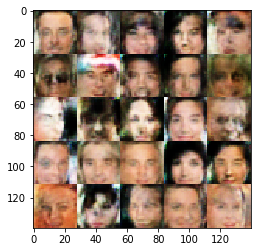

Epoch 1/1 --  Discriminator Loss: 1.4492 --  Generator Loss: 0.4366
Epoch 1/1 --  Discriminator Loss: 1.1415 --  Generator Loss: 1.1934
Epoch 1/1 --  Discriminator Loss: 1.0054 --  Generator Loss: 1.6964
Epoch 1/1 --  Discriminator Loss: 1.0387 --  Generator Loss: 1.0280
Epoch 1/1 --  Discriminator Loss: 1.4101 --  Generator Loss: 1.8447
Epoch 1/1 --  Discriminator Loss: 1.0666 --  Generator Loss: 0.8673
Epoch 1/1 --  Discriminator Loss: 0.6752 --  Generator Loss: 1.8004
Epoch 1/1 --  Discriminator Loss: 1.6284 --  Generator Loss: 0.3706
Epoch 1/1 --  Discriminator Loss: 1.1196 --  Generator Loss: 1.6518
Epoch 1/1 --  Discriminator Loss: 0.9212 --  Generator Loss: 1.2213


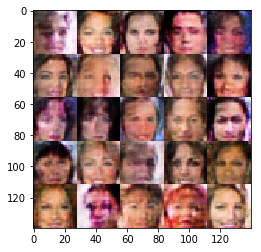

Epoch 1/1 --  Discriminator Loss: 1.5680 --  Generator Loss: 2.1462
Epoch 1/1 --  Discriminator Loss: 0.9307 --  Generator Loss: 1.4429
Epoch 1/1 --  Discriminator Loss: 1.3233 --  Generator Loss: 0.6847
Epoch 1/1 --  Discriminator Loss: 1.0083 --  Generator Loss: 0.8938
Epoch 1/1 --  Discriminator Loss: 0.8421 --  Generator Loss: 1.6380
Epoch 1/1 --  Discriminator Loss: 1.7014 --  Generator Loss: 2.2373
Epoch 1/1 --  Discriminator Loss: 1.1637 --  Generator Loss: 1.3134
Epoch 1/1 --  Discriminator Loss: 1.1352 --  Generator Loss: 0.6713
Epoch 1/1 --  Discriminator Loss: 0.7458 --  Generator Loss: 1.4412
Epoch 1/1 --  Discriminator Loss: 0.5838 --  Generator Loss: 1.9057


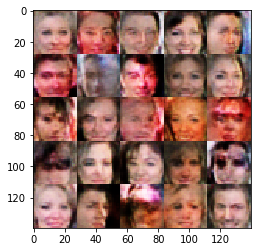

Epoch 1/1 --  Discriminator Loss: 2.0713 --  Generator Loss: 2.4952
Epoch 1/1 --  Discriminator Loss: 1.4589 --  Generator Loss: 0.3673
Epoch 1/1 --  Discriminator Loss: 1.1700 --  Generator Loss: 0.7472
Epoch 1/1 --  Discriminator Loss: 1.3195 --  Generator Loss: 0.6121
Epoch 1/1 --  Discriminator Loss: 1.2439 --  Generator Loss: 0.5449
Epoch 1/1 --  Discriminator Loss: 0.8312 --  Generator Loss: 1.4474
Epoch 1/1 --  Discriminator Loss: 0.9182 --  Generator Loss: 1.1109
Epoch 1/1 --  Discriminator Loss: 0.9944 --  Generator Loss: 1.3707
Epoch 1/1 --  Discriminator Loss: 0.9492 --  Generator Loss: 1.2725
Epoch 1/1 --  Discriminator Loss: 1.1568 --  Generator Loss: 3.0598


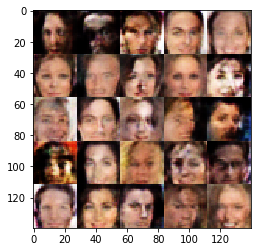

Epoch 1/1 --  Discriminator Loss: 1.1760 --  Generator Loss: 0.7114
Epoch 1/1 --  Discriminator Loss: 0.8526 --  Generator Loss: 1.2571
Epoch 1/1 --  Discriminator Loss: 1.1122 --  Generator Loss: 1.9291
Epoch 1/1 --  Discriminator Loss: 0.6769 --  Generator Loss: 1.4606
Epoch 1/1 --  Discriminator Loss: 1.4411 --  Generator Loss: 0.6673
Epoch 1/1 --  Discriminator Loss: 1.6554 --  Generator Loss: 0.5204


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.